In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from time import time
import numpy as np
from data import get_hsi_data

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
# get data
img = get_hsi_data.get_data()

-- Indian Pines dataset found locally --
-- Completed --


In [4]:
# reshape image as array
from utils.image import img_as_array
img_Vec = img_as_array(img['original'])
img_gt = img_as_array(img['groundtruth'], gt=True)

In [5]:
# normalize the data
from utils.image import standardize
img_Vec = standardize(img_Vec)

In [6]:
# pair x and y with gt
from utils.image import img_gt_idx
X, y = img_gt_idx(img_Vec, img_gt, printinfo=True)

# get training and testing samples
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=.10)

We have 10249 ground-truth samples.
The training data includes 16 classes: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Dimensions of matrix X: (10249, 220)
Dimensions of matrix y: (10249,)


In [7]:
from manifold_learning.lpp import LocalityPreservingProjections

t0 = time()

lpp_model = LocalityPreservingProjections(n_neighbors=20,
                                          neighbors_algorithm='brute',
                                          n_components=50,
                                          sparse=True,
                                          eig_solver='dense')
lpp_model.fit(X_train)
X_proj_train = lpp_model.transform(X_train)
X_proj_test = lpp_model.transform(X_test)
eigVals = lpp_model.eigVals
t1 = time()

print('My LPP class: {t:.2g} secs'.format(t=t1-t0))

Matrices are sparse. Using ARPACK instead.
My LPP class: 0.22 secs


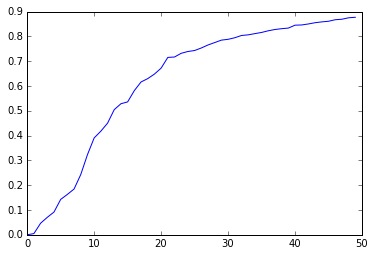

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()

ax.plot(eigVals)
plt.show()

             precision    recall  f1-score   support

          1       0.59      0.60      0.59        40
          2       0.66      0.45      0.54      1304
          3       0.55      0.53      0.54       742
          4       0.33      0.25      0.28       220
          5       0.79      0.78      0.79       423
          6       0.80      0.83      0.81       666
          7       0.41      0.92      0.57        25
          8       0.94      0.95      0.94       421
          9       0.14      0.44      0.22        18
         10       0.49      0.46      0.47       880
         11       0.56      0.72      0.63      2207
         12       0.42      0.36      0.39       537
         13       0.81      0.91      0.86       187
         14       0.90      0.91      0.91      1126
         15       0.56      0.39      0.46       345
         16       1.00      0.86      0.92        84

avg / total       0.65      0.65      0.64      9225



/usr/local/lib/python2.7/dist-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


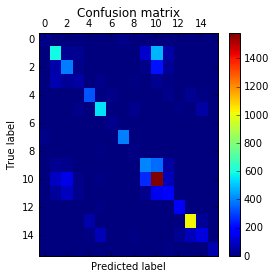

In [9]:
# classification using LDA
from sklearn.lda import LDA

lda_model = LDA()
lda_model.fit(X_proj_train,y_train)
y_pred = lda_model.predict(X_proj_test)

# classification report
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)


print(cr)

plt.figure(figsize=(15,15))
plt.matshow(cm,aspect='auto')
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

(21025, 50)


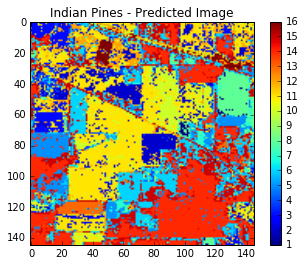

In [10]:
# predict the entire HSI image
t0 = time()
img_Vec_proj = lpp_model.transform(img_Vec)
print(np.shape(img_Vec_proj))
lda_image = lda_model.predict(img_Vec_proj)
t1 = time()

# reshape the image
lda_image = lda_image.reshape(img['original'][:,:,0].shape)


# Look at Ground Truth for Indian Pines
fig, ax = plt.subplots()
h = ax.imshow(lda_image, cmap=plt.cm.jet)
# colorbar_ax = fig.add_axes([0, 16, 1, 2])
fig.colorbar(h, ticks=[np.linspace(1,16,num=16,endpoint=True)])
plt.title('Indian Pines - Predicted Image')
plt.show()

## Jake's Method for doing LPP

My inspiration for coding up this method.

In [ ]:
# jakes algorithm
from lpproj import LocalityPreservingProjection
lpp = LocalityPreservingProjection(n_components=50)

t0 = time()
X_proj_train = lpp.fit_transform(X_train)
X_proj_test = lpp.transform(X_test)
t1=time()
print('My LPP class: {t:.2g} secs'.format(t=t1-t0))

In [ ]:
# classification using LDA
from sklearn.lda import LDA

lda_model = LDA()
lda_model.fit(X_proj_train,y_train)
y_pred = lda_model.predict(X_proj_test)

# classification report
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)


print(cr)

plt.figure(figsize=(15,15))
plt.matshow(cm,aspect='auto')
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()